# SLAM Unit B - Part 2
## *Featureless* localization
As we have seen in Part 1, sometimes there are just not enough landmarks in our field of view. Since our approach needs at least two matching landmarks, we will often loose the ability to correct the position. During such phases, our estimate of the pose will diverge from the true pose, eventually leading to a situation where we are unable to recover.

However, although only a small percentage of the laser scanner measurements hit a landmark, almost all of the remaining measurements are valid as well. They measure the environment, in our case, the boundaries of the arena. Since the environment is static, we may use it for localization as well. This is what we explore in this notebook.

In [1]:
# YouTube = True  # Uncomment this line to get YouTube videos instead of TIB AV.
# If you don't see a video below, run this cell.
from IPython.display import IFrame
IFrame("https://www.youtube.com/embed/kTg7mGL48Jw" if "YouTube" in globals() else "//av.tib.eu/player/48986",
       width=560, height=315)

## Finding correspondences
### Programming assignment: for each point which is close enough to a wall, set up a correspondence (10 Points).
Here are some hints:
- Although this is the case in our arena, do not assume in your code that the left boundary is at $x=0$ (and the lower boundary is at $y=0$).
- As mentioned in the video, if a point is close to two boundaries (e.g. a point in the lower left corner fits `arena_left` *and* `arena_bottom`), pick one of them, in the order in which they appear in the parameter list: `arena_left`, `arena_right`, `arena_bottom`, `arena_top`. For example, if the point fits `arena_left` *and* `arena_bottom`, set up only one correspondence, namely to the projected point on `arena_left`).
- Also keep in mind that points completely outside the arena should not be assigned. For example, even if $x$ fulfills `arena_left`$-\varepsilon < x <$ `arena_left` $+\varepsilon$, there should be no corresponcence if $y$ is outside, i.e., $y\leq$ `arena_bottom` or $y\geq$ `arena_top`.

In [2]:
# Given a set of points, checks for every point p if it is closer than
# eps to the left, right, bottom or top wall of the arena. If so,
# adds the point to left_list, and the closest point on the wall to
# right_list.
def get_corresponding_points_on_wall(points,
                                     arena_left = 0.0, arena_right = 2000.0,
                                     arena_bottom = 0.0, arena_top = 2000.0,
                                     eps = 150.0):
    # YOUR CODE HERE
    left_list=[]
    right_list=[]

    for p in points:
        x,y=p[0],p[1]
        if abs(x-arena_left)<eps and (y-arena_bottom>-eps and y-arena_top<eps):
            left_list.append(p)
            right_list.append((arena_left,y))
        elif abs(x-arena_right)<eps and (y-arena_bottom>-eps and y-arena_top<eps):
            left_list.append(p)
            right_list.append((arena_right,y))
                            
        elif abs(y-arena_bottom)<eps and (x-arena_left>-eps and x-arena_right<eps):
            left_list.append(p)
            right_list.append((x,arena_bottom))
        elif abs(y-arena_top)<eps and (x-arena_left>-eps and x-arena_right<eps):
            left_list.append(p)
            right_list.append((x,arena_top))

    #raise NotImplementedError()
    return left_list, right_list

### Let's test this.
(Let me assure you that this test is actually much longer than the code you are supposed to implement above.)

In [3]:
from random import random, randint
def public_test(the_get_corresponding_points_on_wall):
    # Define all the points in a grid around 0 with borders at +/-1, eps=0.5.
    # Then, according to the precedence rules (left, right, bottom, top) given
    # in the video, the assignment should be:
    #  00000
    #  0ltr0
    #  0l0r0
    #  0lbr0
    #  00000
    # where 0,l,r,b,t corresponds to outside, left, right, bottom, top.
    num_points = 40

    # Make two experiments, one "plain" and one with introduced scale and shift.
    for s, tx, ty in [(1,0,0), (random()+0.5, random()*10-5, random()*10-5)]:
        # Define the points in the range -2.5...2.5 randomly, but avoid
        # "0.5 areas" to guard against rounding errors.
        points = [(random()*0.99-0.5+randint(-2,2),
                   random()*0.99-0.5+randint(-2,2)) for i in range(num_points)]
        cell_indices = [(round(x), round(y)) for (x,y) in points]
        # Left list contains all points which are not outside (in the 0 areas).
        left = [ p for (p, ci) in zip(points, cell_indices)\
                 if ci!=(0,0) and max(abs(ci[0]),abs(ci[1])) <= 1]
        # Right list is more elaborate.
        right = []
        for (p, ci) in zip(points, cell_indices):
            if max(abs(ci[0]),abs(ci[1])) > 1: continue
            if   ci[0] == -1: right.append((  -1, p[1]))  # left
            elif ci[0] ==  1: right.append((   1, p[1]))  # right
            elif ci[1] == -1: right.append((p[0],   -1))  # bottom
            elif ci[1] ==  1: right.append((p[0],    1))  # top
        # Now introduce scale and shift.
        points = [(p[0]*s+tx, p[1]*s+ty) for p in points]
        left   = [(p[0]*s+tx, p[1]*s+ty) for p in left]
        right  = [(p[0]*s+tx, p[1]*s+ty) for p in right]
        
        # Now call user function.
        l, r = the_get_corresponding_points_on_wall(points[:],
            -s+tx, s+tx, -s+ty, s+ty, 0.5*s)
        # First guard against different list lengths.
        if len(l) != len(r):
            print("The returned left and right lists have different length.")
            return False

        # Check if the lists coincide. Sort them to guard against different orders.
        leftright = sorted(zip(left,right))
        lr = sorted(zip(l,r))
        if lr != leftright:
            print("For pointlist:")
            print("".join("(% .4f,% .4f)\n" % p for p in points))
            print("Expected left -> right assignment:")
            print("".join("(% .4f,% .4f)->(% .4f,% .4f)\n" %\
                          (p[0],p[1],q[0],q[1]) for p, q in leftright))
            print("Returned left -> right assignment:")
            print("".join("(% .4f,% .4f)->(% .4f,% .4f)\n" %\
                          (p[0],p[1],q[0],q[1]) for p, q in lr))
            # Mention if results have different length.
            if len(lr) != len(leftright):
                print("Expected and returned lists differ in length.\n")
            # In addition, make a list of different entries.
            print("Entries which are different, expected vs. returned:")
            print("".join(
                "(% .4f,% .4f)->(% .4f,% .4f) vs. "\
                "(% .4f,% .4f)->(% .4f,% .4f)\n" %\
                (pp[0][0], pp[0][1], pp[1][0], pp[1][1],
                 qq[0][0], qq[0][1], qq[1][0], qq[1][1]) \
                for pp, qq in zip(leftright, lr) if pp != qq))
            return False
    return True
assert(public_test(get_corresponding_points_on_wall))

Now that it is tested, execute it to produce `find_wall_pairs.txt` which we will then inspect right after this, using the logfile viewer.

In [4]:
# Subsample the scan. For each point, find a closest point on the
# wall of the arena.
# 05_a_find_wall_pairs
from lego_robot import *
from slam_b_library import filter_step, compute_cartesian_coordinates,\
    write_cylinders

# Takes one scan and subsamples the measurements, so that every sampling'th
# point is taken. Returns a list of (x, y) points in the scanner's
# coordinate system.
def get_subsampled_points(scan, sampling = 10):
    # Subsample from scan
    index_range_tuples = []
    for i in range(0, len(scan), sampling):
        index_range_tuples.append( (i, scan[i]) )
    return compute_cartesian_coordinates(index_range_tuples, 0.0)

if __name__ == '__main__':
    # The constants we used for the filter_step.
    scanner_displacement = 30.0
    ticks_to_mm = 0.349
    robot_width = 150.0

    # The start pose we obtained miraculously.
    pose = (1850.0, 1897.0, 3.717551306747922)

    # Read the logfile which contains all scans.
    logfile = LegoLogfile()
    logfile.read("robot4_motors.txt")
    logfile.read("robot4_scan.txt")

    # Iterate over all positions.
    out_file = open("find_wall_pairs.txt", "w")
    for i in range(len(logfile.scan_data)):
        # Compute the new pose.
        pose = filter_step(pose, logfile.motor_ticks[i],
                           ticks_to_mm, robot_width,
                           scanner_displacement)

        # Subsample points.
        subsampled_points = get_subsampled_points(logfile.scan_data[i])
        world_points = [LegoLogfile.scanner_to_world(pose, c)
                        for c in subsampled_points]

        # Get corresponding points on wall.
        left, right = get_corresponding_points_on_wall(world_points)

        # Write to file.
        # The pose.
        print("F %f %f %f" % pose, file=out_file)
        # Write the scanner points and corresponding points.
        write_cylinders(out_file, "W C", left + right)

    out_file.close()

In [5]:
import ipy_logfile_viewer as lfv
v = lfv.IPYLogfileViewer(files=["find_wall_pairs.txt"])

## Correcting the trajectory using *ICP*

In [6]:
# If you don't see a video below, run this cell.
from IPython.display import IFrame
IFrame("https://www.youtube.com/embed/rM-CajaLZi4" if "YouTube" in globals() else "//av.tib.eu/player/48987",
       width=560, height=315)

### Use the assigned point pairs to estimate a transformation and apply it to the pose.
This is no programming assignment, since there is nothing to do $-$ all required functions are available already.

Since you are working with notebooks right now, the `import` trick discussed in the video is not very handy. However, we still need some functions which you have programmed in *Part 1*. The easiest way to proceed is that you copy & paste the functions `estimate_transform` and `correct_pose`, which were assignments in the *Part 1* notebook, to the cell below, at the indicated locations.

Then, run the following two cells to reproduce the result shown in the video.

In [7]:
# Pasted from Part 1 notebook.
import numpy as np
import math
def compute_center(point_list):
    # Safeguard against empty list.
    if not point_list:
        return (0.0, 0.0)
    # If not empty, sum up and divide.
    sx = sum([p[0] for p in point_list])
    sy = sum([p[1] for p in point_list])
    return (float(sx) / len(point_list), float(sy) / len(point_list))

# Pasted from the Part 1 notebook.
def apply_transform(trafo, p):
    la, c, s, tx, ty = trafo
    lac = la * c
    las = la * s
    x = lac * p[0] - las * p[1] + tx
    y = las * p[0] + lac * p[1] + ty
    return (x, y)

# Since the estimate_transform is in the Part 1 notebook, you will have
# to paste your solution here.
def estimate_transform(left_list, right_list, fix_scale = False):
    # Compute left and right center.
    lc = compute_center(left_list)
    rc = compute_center(right_list)

    # YOUR CODE HERE

    l_p=[]
    r_p=[]
    for i in range (len(left_list)):

        # l_p.append(np.diff([left_list[i],lc]))
        # r_p.append(np.diff([right_list[i],rc])) np.diff rechnet nur die absolute Differenz, stattdessen
        # sollte die Substraktion eingeführt werden
        l_p = [tuple(np.subtract(l,lc)) for l in left_list]
        r_p = [tuple(np.subtract(r,rc)) for r in right_list]

    cs, ss, rr, ll=0.0,0.0,0.0,0.0
    for i in range (len(left_list)):

        cs+=l_p[i][0]*r_p[i][0]+r_p[i][1]*l_p[i][1]
        ss+=-r_p[i][0]*l_p[i][1]+r_p[i][1]*l_p[i][0]
        rr+=r_p[i][0]**2+r_p[i][1]**2
        ll+=l_p[i][0]**2+l_p[i][1]**2

    if fix_scale:
        la = 1.0
    else:
        la = sqrt(rr/ll)
    if cs==0 and ss==0:
        return None
    else:    

    # if cs==0 or ss==0:
    #     return None
    # else:    
        c=cs/math.sqrt(cs**2+ss**2)
        s=ss/math.sqrt(cs**2+ss**2)

    tx=rc[0]-la*(c*lc[0]-s*lc[1])
    ty=rc[1]-la*(s*lc[0]+c*lc[1])
    #raise NotImplementedError()
    return la, c, s, tx, ty

# Also, you will have to paste your solution for correct_pose
# from Part 1 to here.
def correct_pose(pose, trafo):
    # YOUR CODE HERE
    la, c, s, tx, ty =trafo
    x, y ,t=pose
    #raise NotImplementedError()
    [x,y]=apply_transform(trafo, (x,y))
    t=t+atan2(s,c)
    #raise NotImplementedError()
    return (x, y, t)

In [8]:
# Subsample the scan. For each point, find a closest point on the
# wall of the arena.
# From those point pairs, estimate a transform and apply this to the pose.
# 05_b_estimate_wall_transform
from math import sqrt, atan2
from lego_robot import *
from slam_b_library import filter_step, write_cylinders

if __name__ == '__main__':

    # The constants we used for the filter_step.
    scanner_displacement = 30.0
    ticks_to_mm = 0.349
    robot_width = 150.0

    # The start pose we obtained miraculously.
    pose = (1850.0, 1897.0, 3.717551306747922)

    # Read the logfile which contains all scans.
    logfile = LegoLogfile()
    logfile.read("robot4_motors.txt")
    logfile.read("robot4_scan.txt")

    # Iterate over all positions.
    out_file = open("estimate_wall_transform.txt", "w")
    for i in range(len(logfile.scan_data)):
        # Compute the new pose.
        pose = filter_step(pose, logfile.motor_ticks[i],
                           ticks_to_mm, robot_width,
                           scanner_displacement)

        # Subsample points.
        subsampled_points = get_subsampled_points(logfile.scan_data[i])
        world_points = [LegoLogfile.scanner_to_world(pose, c)
                        for c in subsampled_points]

        # Get the transformation
        left, right = get_corresponding_points_on_wall(world_points)
        trafo = estimate_transform(left, right, fix_scale = True)        

        # Correct the initial position using trafo. Also transform points.
        if trafo:
            pose = correct_pose(pose, trafo)
            world_points = [apply_transform(trafo, p) for p in world_points]
        else:
            world_points = []

        # Write to file.
        # The pose.
        print("F %f %f %f" % pose, file=out_file)
        # Write the scanner points and corresponding points.
        write_cylinders(out_file, "W C", world_points)

    out_file.close()

### Look at the result!
This reproduces the result of the first part of the video.

The good thing is that we obtain a corrected trajectory with a shape that looks globally correct. We never get lost!

On the down side, it is not as smooth as we might have expected. When you go through the trajectory step by step, you will see that there are often situations where the wall points are turned with respect to the actual walls. As explained in the video, this is the case since the point correspondences we compute are actually wrong. Below, we will try to fix this using the *ICP* algorithm.

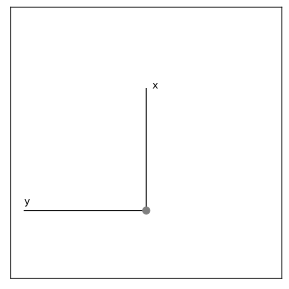

In [9]:
import ipy_logfile_viewer as lfv
v = lfv.IPYLogfileViewer(files=["estimate_wall_transform.txt"])

### Improving the result using *ICP*: programming assignment (15 Points).
*ICP* stands for *iterative closest point* and this just means that we will iterate the steps of *correspondence finding* and *transformation estimation* for a few times.

In [10]:
# ICP: Iterate the steps of transforming the points, selecting point pairs, and
# estimating the transform. Returns the final transformation.
def get_icp_transform(world_points, iterations):
    
    # Iterate assignment and estimation of trafo a few times.
    
    # You may use the following strategy:
    # Start with the identity transform:

    overall_trafo = (1.0, 1.0, 0.0, 0.0, 0.0)
    # Then loop for j in xrange(iterations):
   
    #   Transform the world_points using the curent overall_trafo
    #     (see 05_b on how to do this)
    #   Call get_correspoinding_points_on_wall(...)
    #   Determine transformation which is needed "on top of" the current
    #     overall_trafo: trafo = estimate_transform(...)
    #   Concatenate the found transformation with the current overall_trafo
    #     to obtain a new, 'combined' transformation. You may use the function
    #     overall_trafo = concatenate_transform(trafo, overall_trafo)
    #     to concatenate two similarities.
    #   Note also that estimate_transform may return None.
    # 
    # YOUR CODE HERE 
    for i in range(iterations):
           world_points_trafo=[apply_transform(overall_trafo,p) for p in world_points]
           lf,rf=get_corresponding_points_on_wall(world_points_trafo)

           trafo=estimate_transform(lf, rf, fix_scale= True)

           if trafo:
                  overall_trafo = concatenate_transform(trafo, overall_trafo)
           else:
                  overall_trafo=(1.0, 1.0, 0.0, 0.0, 0.0)
           
    #raise NotImplementedError()

    # Return the final transformation.
    return overall_trafo

### Let's test it!

In [11]:
from math import sin, cos, sqrt, pi

# Returns a new similarity transform, which is the concatenation of
# transform a and b, "a after b".
# The transform is described in the form of:
# (scale, cos(angle), sin(angle), translate_x, translate_y)
# i.e., the angle is described by a direction vector.
def concatenate_transform(a, b):
    laa, ca, sa, txa, tya = a
    lab, cb, sb, txb, tyb = b
    la = laa * lab
    c = ca*cb - sa*sb
    s = sa*cb + ca*sb
    tx = txa + laa * ca * txb - laa * sa * tyb
    ty = tya + laa * sa * txb + laa * ca * tyb
    return (la, c, s, tx, ty)

def public_test(the_get_icp_transform):
    # Here are some test cases: (points, trafo_params), where trafo_params
    # are (rotation_angle, translation_x, translation_y). Note we apply
    # the rotation to the center of the arena, not to the lower left corner.
    test_cases = [
        # Test 0: two points on left bound, one point on bottom, one on top.
        # This defines the transformation completely.
        # First try a shift only.
        ([(0,750),(0,1500),(1500,0),(1500,2000)], (0.0, 30.0, -50.0)),
        # Test 1: same points, now test rotation only.
        ([(0,750),(0,1500),(1500,0),(1500,2000)], (0.1, 0.0, 0.0)),
        # Test 2: same points, now test translation and rotation.
        ([(0,750),(0,1500),(1500,0),(1500,2000)], (0.1, -50.0, 80.0)),
        # Test 3: test 0 without any top point. This will most proabably
        # lead to an error, if fix_scale=False in estimate_transform, because
        # the scale is ambiguous.
        ([(0,750),(0,1500),(750,0),(1500,0)], (0.0, 80.0, -50.0)),
    ]

    # Center of the arena.
    xc, yc = 1000., 1000.

    for i, test in enumerate(test_cases):
        points, trf = test
        c, s, tx, ty = cos(trf[0]), sin(trf[0]), trf[1], trf[2]

        # Transform world points.
        trf_points = [ (c*(x-xc)-s*(y-yc)+xc+tx, s*(x-xc)+c*(y-yc)+yc+ty)\
                       for x,y in points ]

        # Call function to be tested.
        estim_trafo = the_get_icp_transform(trf_points, iterations=500)
        if len(estim_trafo) != 5:
            print("Returned trafo should be a 5-element tuple.")
            return False

        # Compute reference trafo. This is the inverse trafo, and we also
        # have to take into account we are rotating around the center.
        ref_trafo = (1.0, c, -s, xc - c*(xc+tx) - s*(yc+ty),
                     yc + s*(xc+tx) - c*(yc+ty))

        # Check difference.
        if max(abs(e-r) for e, r in zip(estim_trafo, ref_trafo)) > 0.001:
            print("Test %d failed" % i)
            return False
    return True
assert(public_test(get_icp_transform))

After the test, run the following cell to produce the file `icp_wall_transform.txt` which we will look at below.

In [13]:
# Subsample the scan. For each point, find a closest point on the
# wall of the arena.
# From those point pairs, estimate a transform and apply this to the pose.
# Repeat the closest point - estimate transform loop.
# This is an ICP algorithm.
# 05_c_icp_wall_transform
from lego_robot import *
from slam_b_library import filter_step, concatenate_transform,\
    compute_cartesian_coordinates, write_cylinders
from math import sqrt, atan2

if __name__ == '__main__':
    # The constants we used for the filter_step.
    scanner_displacement = 30.0
    ticks_to_mm = 0.349
    robot_width = 150.0

    # The start pose we obtained miraculously.
    pose = (1850.0, 1897.0, 3.717551306747922)

    # Read the logfile which contains all scans.
    logfile = LegoLogfile()
    logfile.read("robot4_motors.txt")
    logfile.read("robot4_scan.txt")

    # Iterate over all positions.
    out_file = open("icp_wall_transform.txt", "w")
    for i in range(len(logfile.scan_data)):
        # Compute the new pose.
        pose = filter_step(pose, logfile.motor_ticks[i],
                           ticks_to_mm, robot_width,
                           scanner_displacement)

        # Subsample points.
        subsampled_points = get_subsampled_points(logfile.scan_data[i])
        world_points = [LegoLogfile.scanner_to_world(pose, c)
                        for c in subsampled_points]

        # Get the transformation 
        trafo = get_icp_transform(world_points, iterations = 40)

        # Correct the initial position using trafo.
        pose = correct_pose(pose, trafo)

        # Write to file.
        # The pose.
        print("F %f %f %f" % pose, file=out_file)
        # Write the scanner points and corresponding points.
        write_cylinders(out_file, "W C",
            [apply_transform(trafo, p) for p in world_points])

    out_file.close()

## Congratulations, you finished Unit B

In [ ]:
# If you don't see a video below, run this cell.
from IPython.display import IFrame
IFrame("https://www.youtube.com/embed/zBe4IfpPRlc" if "YouTube" in globals() else "//av.tib.eu/player/48988",
       width=560, height=315)

### Finally, have a look at the result yourself!
Now, using iterations, we obtain a trajectory which does not only have a shape that looks globally correct, but also is quite smooth. Comparing it to the reference trajectory shows us we obtained a pretty good result.

In [ ]:
import ipy_logfile_viewer as lfv
v = lfv.IPYLogfileViewer(files=["icp_wall_transform.txt", "robot4_reference.txt"])